# Bucket Screening


Let $L_i$  be the positive label proportion of the neighbors of the sample i $(0 <= L_i <=1)$,
and C be the total proportion of the positive labels.
We have N samples.
alpha is the target sampling rate (e.g., alpha = 0.001).

1. Compute the relative probability defined by
  $$ P_i=\left\{
  \begin{array}{@{}ll@{}}
    exp(- lamda ((L_i - C) / (1 - C)), & \text{if}\ L_i >= C \\
    exp(- lamda ((C - L_i) / C), & \text{if}\  L_i < C
  \end{array}\right.$$

2. Create (non-normalized) cumulative distribution
  $$F_0 = 0$$
  $$F_j = \sum_{i=1}^j P_i$$
  
3. Draw alpha $N$ independent random numbers $R_k$ from the uniform distribution between 0 and $F_N$.

4. Choose sample $i$ if any of the random numbers lies in $F_{i-1} <= R_k < F_i$

5. If many samples were chosen twice, iterate Step 2 to Step 5 after removing already chosen samples.

In [336]:
# setup the code
%matplotlib inline

import matplotlib.pyplot as plt
import math
import numpy as np
import numpy.ma as ma
from sklearn import random_projection
from itertools import groupby
from heapq import heappush, heappop
import random
from sklearn import svm
from pylab import rcParams
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.utils import check_random_state

from __future__ import division

# Use seaborn styles for nice-looking plots
import seaborn; seaborn.set()

# define some utility functions
def plotHyperplane(normal, intercept=0, label='', plt=plt):
    """ Plot a hyperplane given a normal and an intercept
    """
    a = -normal[0] / normal[1]
    xx = np.linspace(-10, 10)
    yy = a * xx - (intercept) / normal[1]    
    plt.plot(xx, yy, label=label)    
    return 0

# Hasher
def generateBitString( x ):
    return "".join(['1' if i > 0 else '0' for i in x])

class BucketScreening:
    """BucketScreening class"""

    def maxRatio(self, pos, allPoints):
        return max(pos / allPoints, (allPoints - pos) / allPoints)                 

    def posRatio(self, pos, allPoints):
        return pos / allPoints                 
            
    def __init__(self, bits, features, rnd=42, hashes=10, bias=True, uniform=False, mode='pos'):
        self.hashes = hashes
        self.bias = bias
        self.uniform = uniform
        self.bins = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1, 1.01 ]
        self.ratios =  {
            'pos' : self.posRatio,
            'max' : self.maxRatio
        }
        self.mode = mode
        
        self.rng = check_random_state(rnd) 
        
        self.projections = [random_projection.gaussian_random_matrix(bits, features , random_state=self.rng) for variable in range(hashes)]        
        # intercepts
        if bias:
            if uniform:
                self.intercepts = [rng.rand(bits,1) for variable in range(hashes)]                
            else:
                self.intercepts = [rng.randn(bits,1) for variable in range(hashes)]                
    
    def screen(self, X, Y):
        # first project the data #hashes times
        
        if self.bias:
            projected = [np.apply_along_axis( generateBitString, axis=1, arr=np.dot(X, proj.T ) + self.intercepts[idx].T ) for idx, proj in enumerate(self.projections)]        
        else:
            projected = [np.apply_along_axis( generateBitString, axis=1, arr=np.dot(X, proj.T )) for proj in self.projections]        

        # now generate aggregate stats                
        self.hashtable = []
        
        for buckets in projected:
            stats = dict()
            # aggregate the points to compute the stats
            for key in np.unique(buckets):
                # estimate pos ratio        
                qualifying = Y[buckets == key]
                length = qualifying.shape[0] * 1.0
                # Count how many are positive
                pos = qualifying[qualifying == 1].shape[0]
                
                # Compute dominance using the correct mode
                ratio = self.ratios[self.mode](pos, length)
                
                #print(key,ratio,pos,length)
                stats[key] = ratio
            
            self.hashtable.append(stats)
                        
        #print self.hashtable
        
    def printAverage(self):
        for key, value in stats.iteritems(): 
            self.ratio[key] = sum(value) / len(value)
        
        
    def plotHistogram(self):
        print self.bins
        print self.hist
        width = 0.7 * (self.bins[1] - self.bins[0])
        center = (self.bins[:-1] + self.bins[1:]) / 2
        plt.title('Histogram of point ratio')                    
        #plt.xlim(0.5, 1)    
        plt.bar(center, self.hist, align='center', width=width)
        #plt.xlim(min(self.bins), max(self.bins))        
        #plt.savefig('histogram.pdf')
        plt.show()                
        
    def filter(self, X, Y, min=0.9, max=1):            
        ''' Filter points within range '''
        # first project the data
        if self.bias:
            projected = [np.apply_along_axis( generateBitString, axis=1, arr=np.dot(X, proj.T ) + self.intercepts[idx].T ) for idx, proj in enumerate(self.projections)]        
        else:
            projected = [np.apply_along_axis( generateBitString, axis=1, arr=np.dot(X, proj.T )) for proj in self.projections]        
                        
        # now iterate through projected bitstrings and pick up points that are used
        # compute the score for each point

        X_filtered = []
        
        for p in range(X.shape[0]):        
            strings = [proj[p] for proj in projected]               
            value = []
            for position, item in enumerate(self.hashtable):                            
                value.append(item[strings[position]])
            X_filtered.append(sum(value) / len(value))
        
        X_filtered = np.array(X_filtered)

        #self.hist, self.bins = np.histogram(X_filtered, bins=self.bins)        
        self.hist, self.bins = np.histogram(X_filtered, bins =10, density=False)                

        return (X[(X_filtered >= min) & (X_filtered < max)], Y[(X_filtered >= min) & (X_filtered < max)])      
    
    def sampleFilter(self, X, Y, lambdaParameter = 1, alpha=0.2, rnd=42):
        """ Filter based on sample probability"""
        
        self.rng.seed(rnd)
        
        # compute P_i
        # first project the data
        if self.bias:
            projected = [np.apply_along_axis( generateBitString, axis=1, arr=np.dot(X, proj.T ) + self.intercepts[idx].T ) for idx, proj in enumerate(self.projections)]        
        else:
            projected = [np.apply_along_axis( generateBitString, axis=1, arr=np.dot(X, proj.T )) for proj in self.projections]        
                        
        # now iterate through projected bitstrings and pick up labels that are used
        # compute the score for each point

        # compute C (number of positive points)
        C = (Y[Y == 1].shape[0]) / Y.shape[0] * 1.0
        
        toSample = int(alpha * Y.shape[0])
                
        P_i = []
        lastSum = 0
        
        for p in range(X.shape[0]):        
            strings = [proj[p] for proj in projected]               
            value = []
            for position, item in enumerate(self.hashtable):                            
                value.append(item[strings[position]])
            L_i = sum(value) / len(value)
            if (L_i >= C):
                p = math.exp(- lambdaParameter * ((L_i - C) / (1 - C)))                
            else:
                p = math.exp(- lambdaParameter *  ((C - L_i) / C))
        
            P_i.append(p)
                                
        P_i = np.array(P_i)
        F_i = np.cumsum(P_i)            
        F_i = np.insert(F_i, 0, 0)
        
        # Step 2    
        F_n = np.sum(P_i)        
                
        # alpha * all numbers .. from 0 .. F_n

        # mask defines points to use
        mask = ma.make_mask(np.zeros(Y.shape[0]), shrink=False)
        
        while (mask[mask==True].shape[0] < toSample):
    
        #for x in range(0, toSample):
            # we take the number .. iff Choose sample i if any of the random numbers lies in F_{i-1} <= R_k < F_i
            # so find which bucket it falls into
            R_k = self.rng.uniform(0, F_n)
            
            #print R_k
            for i in range(1, F_i.shape[0]):
                if(F_i[i-1] <= R_k and R_k < F_i[i]):
                    #print i
                    # we take you
                    mask[i - 1] = True
                    break
            
        # if we have too few points go back to step 2
        
        # print mask[mask==True].shape[0]
        
        return (X[mask],Y[mask])

In [337]:
# Now generate some random points
rng = np.random.RandomState(42)
n_samples_1 = 100
n_samples_2 = 100
X = np.r_[2 * rng.randn(n_samples_1, 2) - [2,2],
          1* rng.randn(n_samples_2, 2) + [2, 2]]
Y = np.array([0] * (n_samples_1) + [1] * (n_samples_2))

#rom sklearn.preprocessing import normalize
# = normalize(X, axis=1, norm='l2')

from sklearn import preprocessing

# = preprocessing.scale(X)

Wall time: 15 ms
[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
[86  6  4  2  2  1  2  1  7 89]


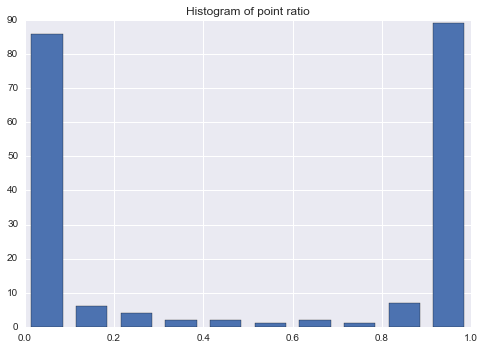

In [338]:
screen = BucketScreening(6, X.shape[1], hashes=10, bias=True, uniform=True, mode='pos')

# 6, 100
# good 5 bits, hashes 100

%time screen.screen(X,Y)

reducedX, reducedY = screen.filter(X,Y, min=0.5,max=1)
screen.plotHistogram()

20
Our Method lambda 1   0.970000 with 20 points
20
Our Method lambda 5   0.980000 with 20 points
20
Our Method lambda 10   0.985000 with 20 points
20
Our Method lambda 20   0.985000 with 20 points
Entire Dataset  0.980000 with 200 points (14 sv)


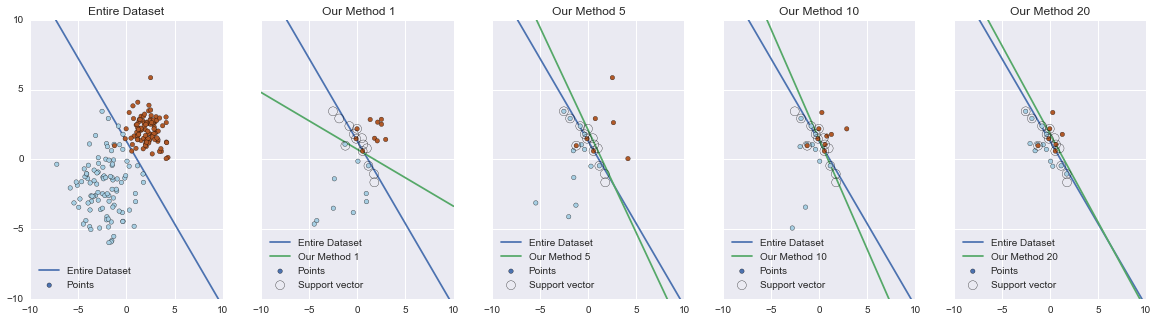

In [339]:
# Now compute P_i for each point
# train svm on the entire data
entire = svm.SVC(kernel='linear')
entire.fit(X,Y)  

## from pylab import rcParams
rcParams['figure.figsize'] = 20, 5
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, sharex=True)
# plot the random svm 
  
ax1.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired, label='Points')
ax1.set_title('Entire Dataset')    

#ax2.scatter(reducedX[:, 0], reducedX[:, 1], c=reducedY, zorder=10, cmap=plt.cm.Paired, label='Points')
#ax2.set_title('Mixed Buckets')    

#sets = [[0.73, 0.86],[0.6,0.85],[0.85,0.90],[0.9, 0.95]]
sets = [1,5,10,20]

plotHyperplane(entire.coef_[0],entire.intercept_[0],plt=ax1,label='Entire Dataset')

count = 0;
for plot in (ax2, ax3, ax4, ax5):
    plotHyperplane(entire.coef_[0],entire.intercept_[0],plt=plot,label='Entire Dataset')
    s = 0
    try:
        reducedX, reducedY = screen.sampleFilter(X,Y, lambdaParameter=sets[count], alpha=0.1, rnd = 42)
        plot.scatter(reducedX[:, 0], reducedX[:, 1], c=reducedY, zorder=10, cmap=plt.cm.Paired, label='Points')

        reduced = svm.SVC(kernel='linear')
        reduced.fit(reducedX, reducedY)
        s = reduced.score(X,Y)
        plotHyperplane(reduced.coef_[0],reduced.intercept_[0],plt=plot,label='Our Method ' + str(sets[count]))        

    except (ValueError, IndexError):        
        pass    

    print('Our Method lambda %s   %f with %d points' % (str(sets[count]),s ,reducedX.shape[0] ))    

    plot.set_title('Our Method ' + str(sets[count]))    
    plot.scatter(entire.support_vectors_[:, 0], entire.support_vectors_[:, 1], s=80,
                facecolors='none', zorder=10, label='Support vector')
    plot.legend(loc='lower left')
   
    count = count + 1
    

    
    
#plt.scatter(X_selected[:,0], X_selected[:,1],  s=80,
#                facecolors='none', zorder=10, label='Selected Points')

ax1.set_xlim([-10,10])
ax1.set_ylim([-10,10])    
ax1.legend(loc='lower left')
#ax1.show()
print('Entire Dataset  %f with %d points (%d sv)'% (entire.score(X,Y),X.shape[0], entire.support_vectors_.shape[0]))

